In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import os
import argparse
import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from Scattering import Scattering
from ScatteringExp import ScatteringExp
from Grid import Grid
import RseSolver
from scipy.special import factorial2, spherical_jn
from plots.rc_params import *

In [2]:
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
l = 0
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
E_MeV = 50
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
rmatch = 12
grid = Grid(1e-24, rmatch, numIntervals=1, numPointsPerInterval=12,
            type="linear", test=False)  # needs equidistant grids as of now
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

from NumerovEmulator import AffineGROM
# Test config for no greedy
emulator_pod = AffineGROM(scattExp=scattExp, 
                          grid=grid, 
                          free_lecs={"V0": (0, 400)},
                          num_snapshots_init=80, 
                          num_snapshots_max=100,
                          approach="pod", 
                          pod_rcond=1e-12, 
                          init_snapshot_lecs=None,
                          greedy_max_iter=5, 
                          mode="linear"
                          )

testing
4.336808689942018e-19


AssertionError: matching may use too many points

In [84]:
from RseSolver import RseSolver
inhomogeneous=True
args = dict(asympParam="K", matching=True)
solver = RseSolver(scattExp=scattExp, grid=grid, inhomogeneous=inhomogeneous)
num1  = solver.solve(lecList=testingLecList, method="Numerov_affine", **args)
num2  = solver.solve(lecList=testingLecList, method="Numerov", **args)
# numk  = solver.solve(lecList=testingLecList, method="RK45", **args)
print("diff", np.max(np.abs(num1[0].u-num2[0].u)))
# print("diff", np.max(np.abs(numk[0].u-num2[0].u)))
print(num1[0].Lmatrix.value)

testing
4.336808689942018e-19


AssertionError: matching may use too many points

In [6]:
rseParams = {"grid": grid, "scattExp": scattExp, "potential": scattExp.potential, 
             "inhomogeneous": True, 
             "asympParam": "K", "method": "lsqfit", 
             "matching": False,
             "lecs": testingLecList[0]
             }

In [5]:
from Numerov import numerov2
from RseSolver import g, s
_, _, sol = numerov2(grid.points, y0=0, g=g, s=s, solve=True, params=rseParams)
plt.plot(grid.points, sol[:-1])
plt.ylim(-2,2)
print("Kmat", sol[-1])
print(sol[-3:-1])

cond: 16.20271465864257
[[ 0.          1.1408836   1.1187702   1.11729146  1.11726029  1.11726007  1.11726007  1.11726007  1.11726007  1.11726007  1.11726007 -0.83441471]
 [-0.37905521 -0.59116396 -0.81229795 -0.82708544 -0.82739711 -0.82739926 -0.82739927 -0.82739927 -0.82739927 -0.82739927  0.         -0.81703988]
 [ 1.16209448  1.1408836   1.1187702   1.11729146  1.11726029  1.11726007  1.11726007  1.11726007  1.11726007  1.          1.          0.        ]]


ValueError: too many values to unpack (expected 3)

In [205]:
0.12807611082345854 - 0.12807611095053156

-1.2707301877412647e-10

In [199]:
ref = 0.30244898361777356 
print(ref- 0.3024489841826322)
print(ref - 0.3024489834047703)

-5.648586598461236e-10
2.1300328167939142e-10


In [136]:
F_G = np.array([[-0.9925143,  -0.12212848],
 [-0.99993406, -0.01148347]])

sol[-2] - sol[-1]*F_G[1,1]

-0.9999340553206375

In [53]:
testingLecList[0]

{'V0': 200, 'V1': -91.85, 'K0': 1.487, 'K1': 0.465}

In [41]:
np.set_printoptions(edgeitems=10, linewidth=400)
from Numerov import EverythingAllAtOnceNumerov
from RseSolver import g_s, g_s_affine
aa = EverythingAllAtOnceNumerov(xn=grid.points, g=None, 
                                g_s=g_s_affine, params=rseParams)
lecs = np.array([1,200,-91.85])
print(aa.S_tensor.shape)
abar = np.tensordot(lecs, aa.Abar_tensor, axes=1)
ss = np.tensordot(lecs, aa.S_tensor, axes=1)
abar

(3, 12)


array([[ 0.        ,  1.1408836 ,  1.1187702 ,  1.11729146,  1.11726029,  1.11726007,  1.11726007,  1.11726007,  1.11726007,  1.11726007,  1.11726007, -0.83441471],
       [-0.37905521, -0.59116396, -0.81229795, -0.82708544, -0.82739711, -0.82739926, -0.82739927, -0.82739927, -0.82739927, -0.82739927,  0.        , -0.81703988],
       [ 1.16209448,  1.1408836 ,  1.1187702 ,  1.11729146,  1.11726029,  1.11726007,  1.11726007,  1.11726007,  1.11726007,  1.        ,  1.        ,  0.        ]])

In [33]:
import scipy as sp
np.max(np.abs(sol - np.concatenate(([0],sp.linalg.solve_banded((1,1), ab=abar, b=ss)))))

2.7755575615628914e-15

In [51]:
aa.A_tensor

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.]])

In [27]:
sol

array([ 0.        ,  1.02730723, -0.01778524, -1.2408316 , -0.9024043 ,  0.55244502,  1.30496469,  0.43205144, -0.96522355, -1.15054957,  0.0907037 ,  1.20505704,  0.76921078])

In [23]:
np.max(np.abs(ab-abar))

5.551115123125783e-16

cond: 16.20271465864257
[[ 0.          1.1408836   1.1187702   1.11729146  1.11726029  1.11726007  1.11726007  1.11726007  1.11726007  1.11726007  1.11726007 -0.83441471]
 [-0.37905521 -0.59116396 -0.81229795 -0.82708544 -0.82739711 -0.82739926 -0.82739927 -0.82739927 -0.82739927 -0.82739927  0.         -0.81703988]
 [ 1.16209448  1.1408836   1.1187702   1.11729146  1.11726029  1.11726007  1.11726007  1.11726007  1.11726007  1.          1.          0.        ]]
Kmat 0.7692107803100704
[0.0907037  1.20505704]


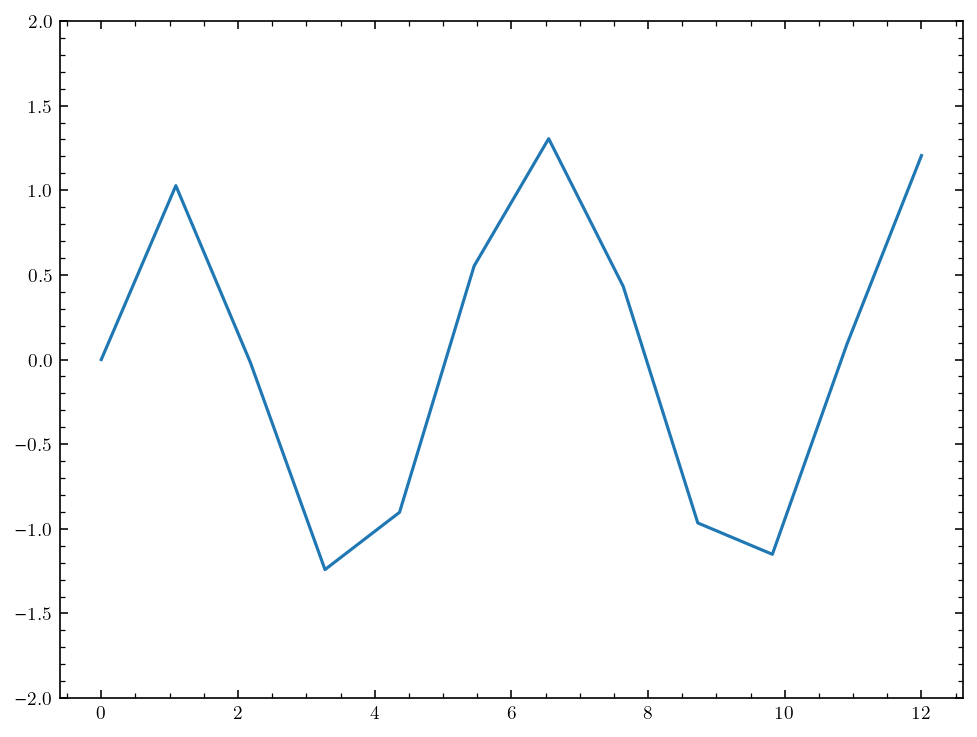

In [21]:
from Numerov import numerov2
from RseSolver import g, s
absp, ab, s, sol = numerov2(grid.points, y0=0, g=g, s=s, solve=True, params=rseParams)
plt.plot(grid.points, sol[:-1])
plt.ylim(-2,2)
print("Kmat", sol[-1])
print(sol[-3:-1])

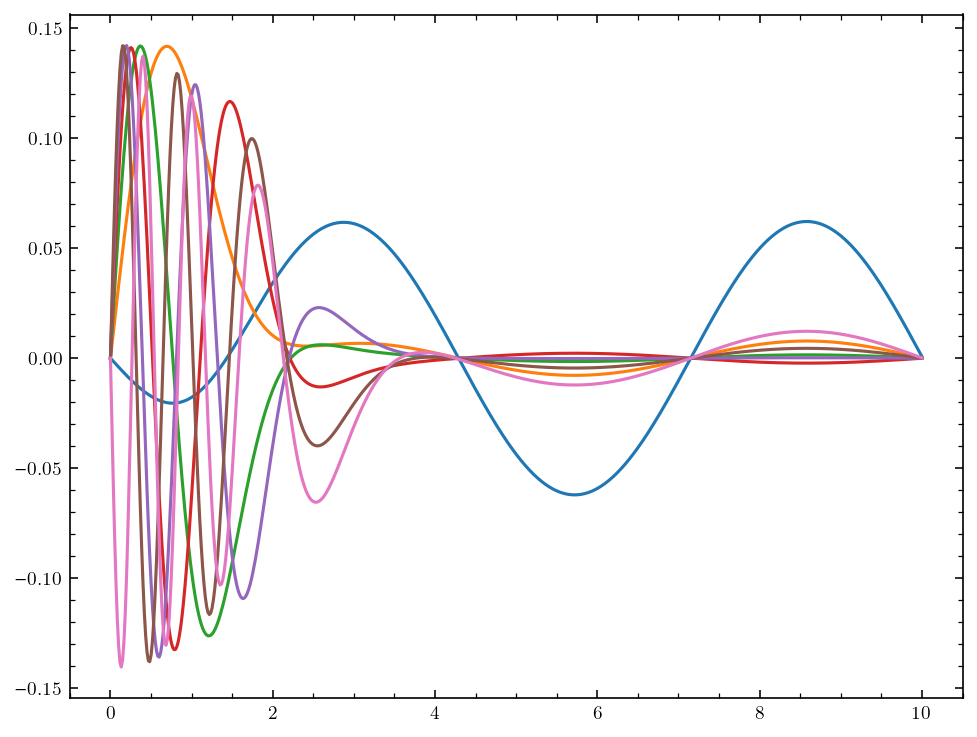

In [185]:
plt.plot(emulator_pod.grid.points, emulator_pod.snapshot_matrix)
# for line in np.arange(0,5,2) * np.pi/2:
    # plt.axvline(line)

In [186]:
emulator_pod.snapshot_matrix

array([[-7.90348363e-16, -5.64756977e-17, -1.32624990e-14, ...,
        -1.56450719e-10, -2.81064521e-08,  6.96212340e-06],
       [-6.76500397e-04,  5.53254186e-03,  1.01747709e-02, ...,
         1.92123481e-02,  2.37291535e-02, -2.77768238e-02],
       [-1.35233318e-03,  1.10560860e-02,  2.02959416e-02, ...,
         3.80695978e-02,  4.67902952e-02, -5.44494709e-02],
       ...,
       [ 2.98981443e-03,  3.75770293e-04,  7.30255126e-05, ...,
         8.55398566e-06,  2.15828667e-04,  5.88893712e-04],
       [ 1.85181953e-03,  2.32743129e-04,  4.52302537e-05, ...,
         5.29813339e-06,  1.33678660e-04,  3.65086282e-04],
       [ 7.13201953e-04,  8.96377042e-05,  1.74197861e-05, ...,
         2.04050117e-06,  5.14834560e-05,  1.41375482e-04]])

In [187]:
print(emulator_pod.snapshot_Lvec.shape)
emulator_pod.Lmatrix(np.ones(7))

(7,)


-0.08606388580146387

In [192]:
[elem.Lmatrix.value for elem in emulator_pod.snapshot_matrix2]

[1.7892471497074987,
 1.6987177548176522,
 1.614932468440648,
 1.5371342217896067,
 1.4646753517903086,
 1.3969985240801437,
 1.3336215132813174,
 1.2741249603035758,
 1.2181424487547734,
 1.165352403621352,
 1.115471433415937,
 1.0682488243921677,
 1.0234619607583646,
 0.9809124941570403,
 0.9404231231823899,
 0.9018348725310875,
 0.865004783622441,
 0.8298039458828939,
 0.7961158114672985,
 0.7638347469293145,
 0.7328647838590323,
 0.7031185373147608,
 0.6745162663318218,
 0.6469850551996709,
 0.6204580977770938,
 0.5948740700251868,
 0.570176578327663,
 0.5463136731297776,
 0.5232374190470954,
 0.5009035139392716,
 0.47927095056484714,
 0.4583017153633796,
 0.4379605196975707,
 0.41821455954759507,
 0.39903330020175065,
 0.38038828296379124,
 0.3622529512928067,
 0.34460249413452865,
 0.32741370449254753,
 0.3106648515375381,
 0.29433556476579786,
 0.2784067289040195,
 0.26286038841315496,
 0.24767966058582389,
 0.23284865634637078,
 0.21835240796981822,
 0.2041768030236896,
 0.1903

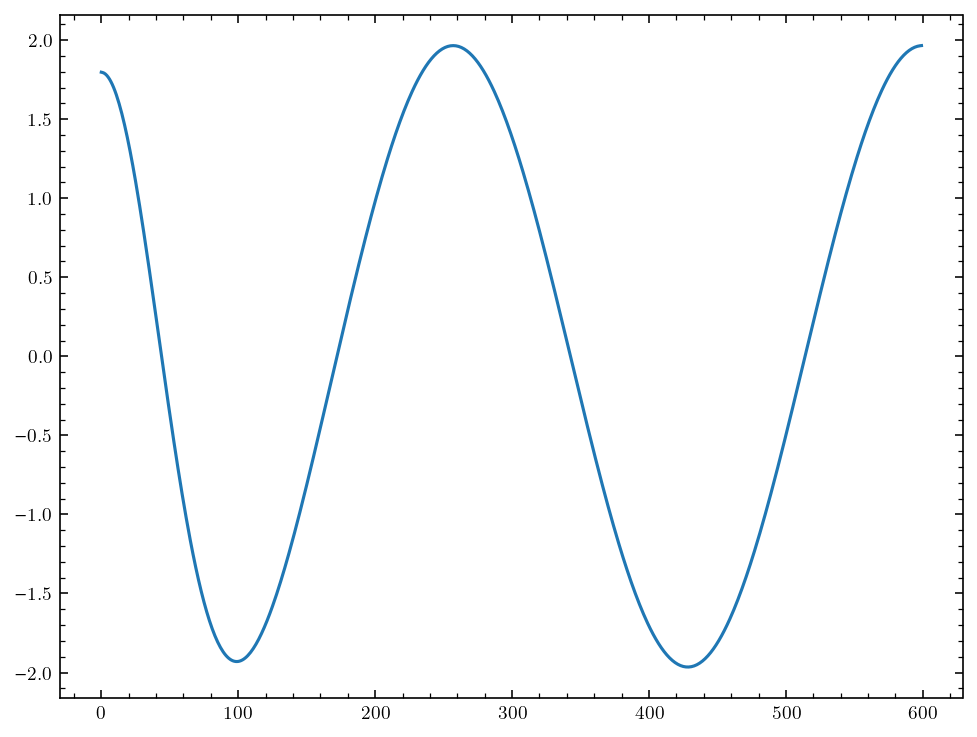

In [188]:
plt.plot(emulator_pod.snapshot_matrix2[0].chiprime)

In [157]:
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

# New emulator